# Cardiovascular Disease Prediction
Classification goal: predict 10-year risk of coronary heart disease (CHD).

Data: sourced from Kaggle. It is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. It includes 3,390 records, 15 attributes (risk factors), and the target variable—CHD morbidity.

Variables:
Each attribute is a potential risk factor: demographic, behavioral, or medical.

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore', module="choreographer.browser_async")
from sklearn.linear_model import LogisticRegression  
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, precision_recall_curve, f1_score, average_precision_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import numpy as np
df = pd.read_csv("train.csv", index_col=0)
print(df.shape) # (rows, columns)
df.sample(5)

(3390, 16)


,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
364,37,2.0,M,NO,0.0,0.0,0,1,0,225.0,124.5,92.5,38.53,95.0,83.0,0
3283,50,2.0,F,NO,0.0,0.0,0,0,0,210.0,105.0,77.0,23.96,60.0,86.0,0
3339,49,3.0,M,NO,0.0,0.0,0,1,0,221.0,175.0,107.5,25.97,63.0,78.0,0
1959,64,1.0,F,NO,0.0,0.0,0,1,0,232.0,149.5,84.0,20.49,68.0,96.0,0
714,49,2.0,M,YES,5.0,0.0,0,0,0,260.0,111.0,70.0,24.24,75.0,87.0,0


Data Description
- age: age of the patient
- education: some high school (1), high school/GED (2), some college/vocational school (3), college (4)
- sex: male or female (M/F)
- is_smoking: whether the patient is a current smoker (YES/NO)
- cigsPerDay: the number of cigarettes the person smoked on average per day
- BPMeds: whether the patient was on blood pressure medication (binary: “1” = “Yes”, “0” = “No”)
- prevalentStroke: whether the patient had previously had a stroke (binary: “1” = “Yes”, “0” = “No”)
- prevalentHyp: whether the patient was hypertensive (binary: “1” = “Yes”, “0” = “No”)
- diabetes: whether the patient had diabetes (binary: “1” = “Yes”, “0” = “No”)
- totChol: total cholesterol level (continuous, mg/dL)
- sysBP: systolic blood pressure (continuous, mmHg)
- diaBP: diastolic blood pressure (continuous, mmHg)
- BMI: Body Mass Index (continuous)
- heartRate: heart rate (continuous, BPM)
- glucose: glucose level (continuous, mg/dL)
- TenYearCHD: whether the patient has coronary heart disease (binary: “1” = “Yes”, “0” = “No”)

 ## Data Preprocessing

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


In [129]:
# Changing dtypes of binary categorical variables for less memory usage
binary_cols = ["prevalentStroke", "prevalentHyp", "diabetes", "TenYearCHD"]
df[binary_cols] = df[binary_cols].astype("int8")

In [130]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,3390.0,NaN,NaN,NaN,49.542183,8.592878,32.0,42.0,49.0,56.0,70.0
education,3303.0,NaN,NaN,NaN,1.970936,1.019081,1.0,1.0,2.0,3.0,4.0
sex,3390,2,F,1923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_smoking,3390,2,NO,1703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cigsPerDay,3368.0,NaN,NaN,NaN,9.069477,11.879078,0.0,0.0,0.0,20.0,70.0
BPMeds,3346.0,NaN,NaN,NaN,0.029886,0.170299,0.0,0.0,0.0,0.0,1.0
prevalentStroke,3390.0,NaN,NaN,NaN,0.00649,0.080309,0.0,0.0,0.0,0.0,1.0
prevalentHyp,3390.0,NaN,NaN,NaN,0.315339,0.464719,0.0,0.0,0.0,1.0,1.0
diabetes,3390.0,NaN,NaN,NaN,0.025664,0.158153,0.0,0.0,0.0,0.0,1.0
totChol,3352.0,NaN,NaN,NaN,237.074284,45.24743,107.0,206.0,234.0,264.0,696.0


In [131]:
# Checking unique values of string variables for encoding
print(df["sex"].unique())
print(df["is_smoking"].unique())

['F' 'M']
['YES' 'NO']


In [132]:
# Encoding string variables into integers
df["sex"] = df["sex"].map({'M': 1, 'F': 0})
df["is_smoking"] = df["is_smoking"].map({'YES': 1, 'NO': 0})


In [133]:
print(df["sex"].unique())
print(df["is_smoking"].unique())

[0 1]
[1 0]


In [134]:
print("Number of nulls:", df.isnull().sum().sum())
print("Number of duplicate rows:", df.duplicated().sum())

Number of nulls: 510
Number of duplicate rows: 0


In [135]:
# Handling missing values
pd.DataFrame({'Count':df.shape[0],
              'Null':df.isnull().sum(),
              'Null %':df.isnull().mean() * 100,
              'Unique:':df.nunique()
})

,Count,Null,Null %,Unique:
age,3390,0,0.000000,39
education,3390,87,2.566372,4
sex,3390,0,0.000000,2
is_smoking,3390,0,0.000000,2
cigsPerDay,3390,22,0.648968,32
BPMeds,3390,44,1.297935,2
prevalentStroke,3390,0,0.000000,2
prevalentHyp,3390,0,0.000000,2
diabetes,3390,0,0.000000,2
totChol,3390,38,1.120944,240


In [136]:
imputer_cat = SimpleImputer(strategy="most_frequent")
df[["BPMeds", "education"]] = imputer_cat.fit_transform(df[["BPMeds", "education"]])

imputer = IterativeImputer()
df[["glucose","cigsPerDay", "totChol", "BMI", "heartRate"]] = imputer.fit_transform(
    df[["glucose", "cigsPerDay", "totChol", "BMI", "heartRate"]]
)


In [137]:
pd.DataFrame({'Count':df.shape[0],
              'Null':df.isnull().sum(),
              'Null %':df.isnull().mean() * 100,
              'Unique:':df.nunique()
})

,Count,Null,Null %,Unique:
age,3390,0,0.0,39
education,3390,0,0.0,4
sex,3390,0,0.0,2
is_smoking,3390,0,0.0,2
cigsPerDay,3390,0,0.0,54
BPMeds,3390,0,0.0,2
prevalentStroke,3390,0,0.0,2
prevalentHyp,3390,0,0.0,2
diabetes,3390,0,0.0,2
totChol,3390,0,0.0,278


In [138]:
# Converting education dtype after null handling
df["education"] = df["education"].astype("int8")

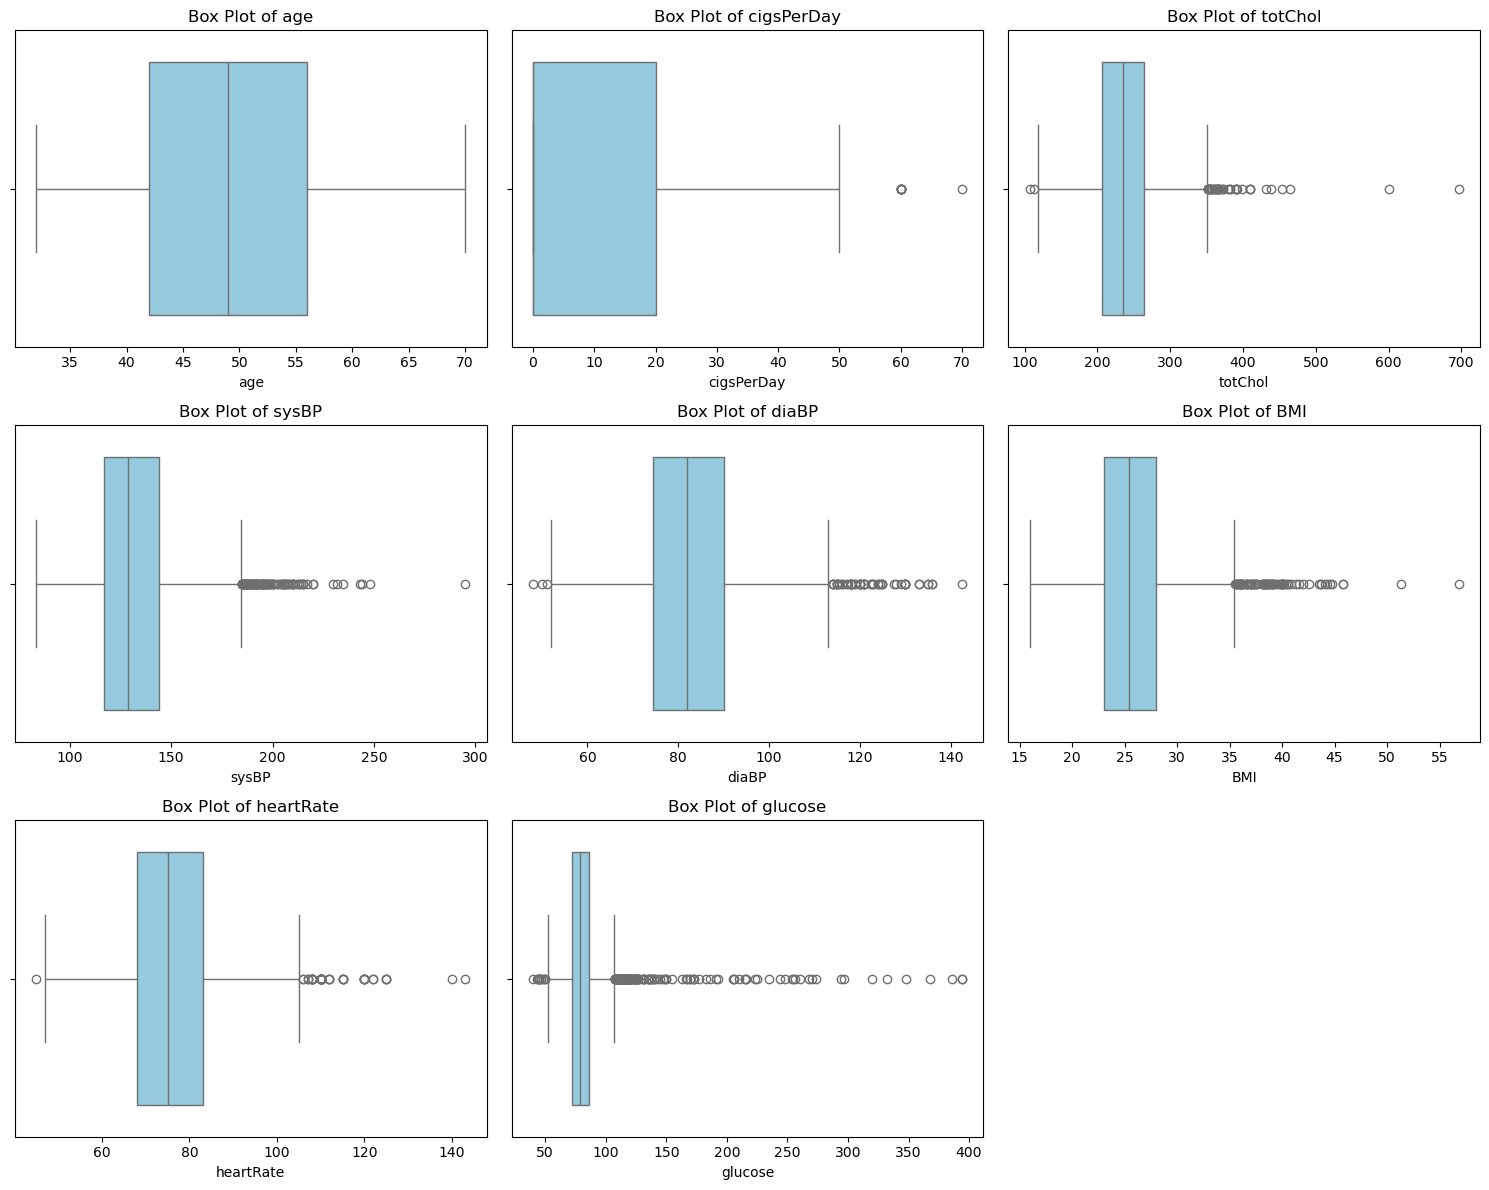

In [139]:
# Outlier overview in box plots
numerical_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP','diaBP', 'BMI', 'heartRate', 'glucose']
plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

Although a significant number of upper-end outliers are present, they are medically plausible and may represent patients with genuine risk factors or underlying conditions.
Therefore, all values are retained to ensure the model reflects the full spectrum of patient health and risk in the population.
Because the data is right-skewed, robust scaling is performed to reduce the influence of extreme values and improve model performance.

## Exploratory Data Analysis

In [140]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,3390.0,49.542183,8.592878,32.00,42.00,49.000000,56.000,70.0
education,3390.0,1.946018,1.017568,1.00,1.00,2.000000,3.000,4.0
sex,3390.0,0.432743,0.495529,0.00,0.00,0.000000,1.000,1.0
is_smoking,3390.0,0.497640,0.500068,0.00,0.00,0.000000,1.000,1.0
cigsPerDay,3390.0,9.069363,11.840721,0.00,0.00,0.000000,20.000,70.0
BPMeds,3390.0,0.029499,0.169224,0.00,0.00,0.000000,0.000,1.0
prevalentStroke,3390.0,0.006490,0.080309,0.00,0.00,0.000000,0.000,1.0
prevalentHyp,3390.0,0.315339,0.464719,0.00,0.00,0.000000,1.000,1.0
diabetes,3390.0,0.025664,0.158153,0.00,0.00,0.000000,0.000,1.0
totChol,3390.0,237.087554,44.995839,107.00,206.00,234.586753,264.000,696.0


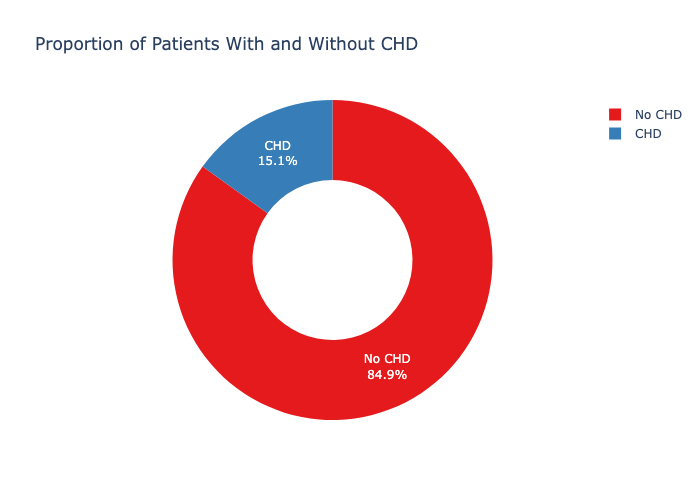

In [141]:
chd_counts = df['TenYearCHD'].value_counts().sort_index()
labels = ['No CHD', 'CHD']
fig = px.pie(
    names=labels,
    values=chd_counts.values,
    title='Proportion of Patients With and Without CHD',
    hole=0.5,
    color_discrete_sequence=px.colors.qualitative.Set1
)
fig.update_traces(textinfo='percent+label')
fig.write_image("plot.png")
display(Image(filename="plot.png"))

Notably, the target variable is imbalanced: the large majority of study participants do not have CHD. This could result in poorer detection of CHD cases, as models are biased toward predicting majority class.

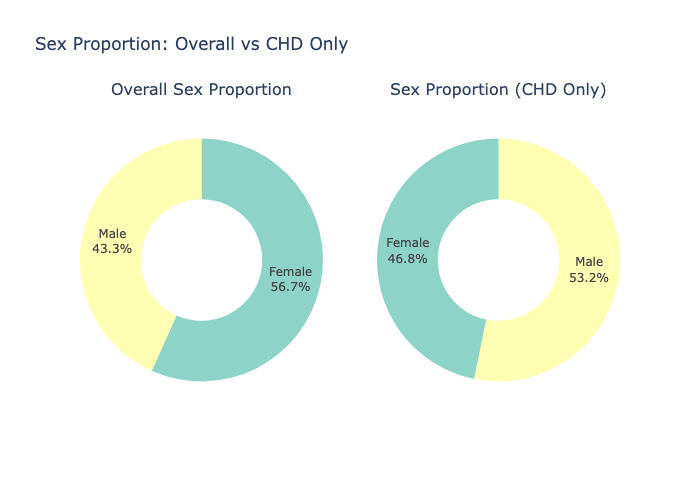

In [142]:
sex_counts = df['sex'].value_counts().sort_index()
sex_labels = ['Female', 'Male']

sex_chd_counts = df[df['TenYearCHD'] == 1]['sex'].value_counts().sort_index()
sex_chd_labels = ['Female', 'Male']

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], subplot_titles=['Overall Sex Proportion', 'Sex Proportion (CHD Only)'])

fig.add_trace(go.Pie(labels=sex_labels, values=sex_counts.values, hole=0.5, name='Sex', marker_colors=px.colors.qualitative.Set3), 1, 1)
fig.add_trace(go.Pie(labels=sex_chd_labels, values=sex_chd_counts.values, hole=0.5, name='Sex (CHD)', marker_colors=px.colors.qualitative.Set3), 1, 2)

fig.update_traces(textinfo='percent+label')
fig.update_layout(title_text='Sex Proportion: Overall vs CHD Only', showlegend=False)
fig.write_image("plot.png")
display(Image(filename="plot.png"))

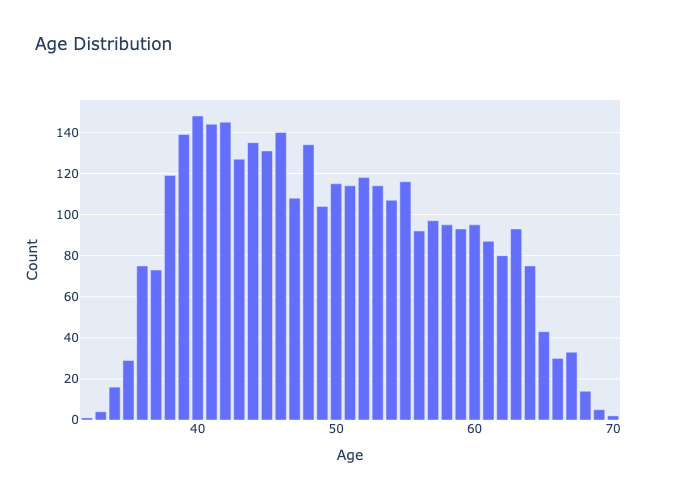

In [143]:
age_counts = df['age'].value_counts().sort_index()
fig = px.bar(x=age_counts.index, y=age_counts.values, labels={'x': 'Age', 'y': 'Count'}, title='Age Distribution')
fig.write_image("plot.png")
display(Image(filename="plot.png"))

Median Age for TenYearCHD=0: 48.0
Median Age for TenYearCHD=1: 55.0


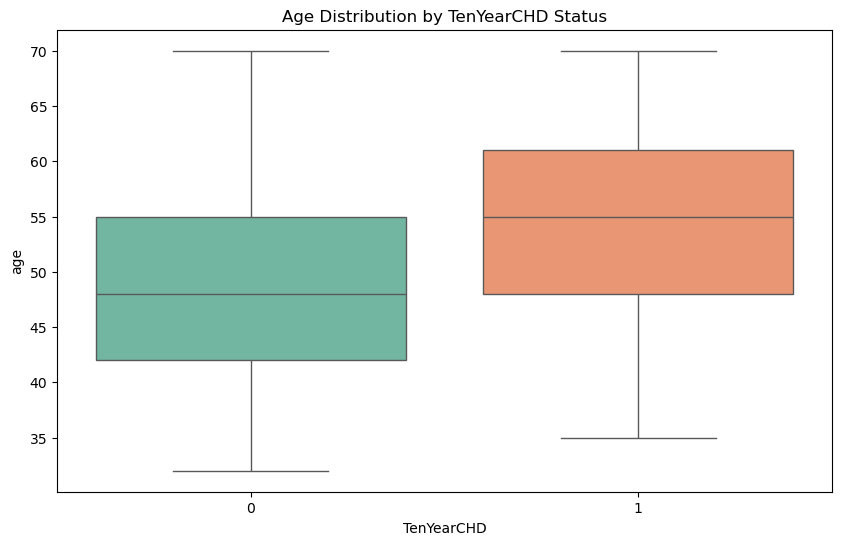

In [144]:
medians = df.groupby('TenYearCHD')['age'].median()
print('Median Age for TenYearCHD=0:', medians[0])
print('Median Age for TenYearCHD=1:', medians[1])
plt.figure(figsize=(10, 6))
sns.boxplot(x='TenYearCHD', y='age', data=df, palette='Set2')
plt.title('Age Distribution by TenYearCHD Status')
plt.show()

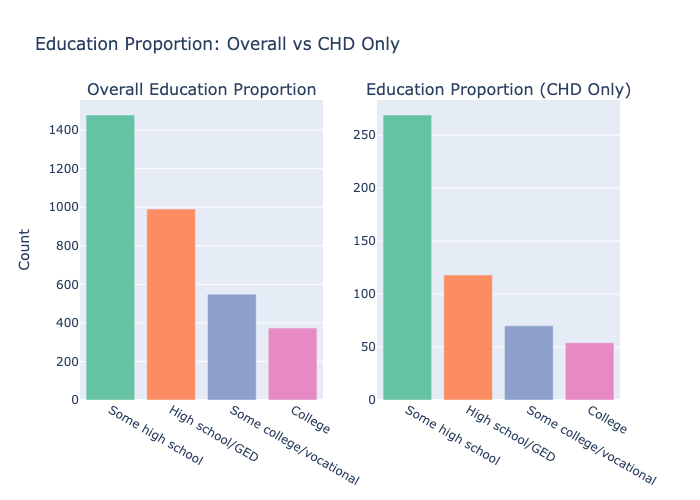

In [145]:
edu_labels = ['Some high school', 'High school/GED', 'Some college/vocational', 'College']
edu_counts = df['education'].value_counts().sort_index()

edu_chd_counts = df[df['TenYearCHD'] == 1]['education'].value_counts().sort_index()

fig = make_subplots(rows=1, cols=2, subplot_titles=['Overall Education Proportion', 'Education Proportion (CHD Only)'])

fig.add_trace(go.Bar(x=edu_labels, y=edu_counts.values, marker_color=px.colors.qualitative.Set2, name='Education'), 1, 1)
fig.add_trace(go.Bar(x=edu_labels, y=edu_chd_counts.values, marker_color=px.colors.qualitative.Set2, name='Education (CHD)'), 1, 2)

fig.update_layout(title_text='Education Proportion: Overall vs CHD Only', showlegend=False, yaxis_title='Count')
fig.write_image("plot.png")
display(Image(filename="plot.png"))

- Age distribution is balanced. The median study participant is middle-aged (49 y/o). CHD+ participants have a higher median age (55 y/o) than others (44 y/o).
- The study population is majority female; however, males have relatively higher CHD rates.
- "Some high school" (1) is a more common education level in the CHD group; expecting a negative correlation.

In [146]:
# Table: Percentage and raw counts of TenYearCHD=1 for binary variables (0 vs 1 groups)
binary_vars = ['is_smoking', 'prevalentHyp', 'prevalentStroke', 'BPMeds', 'diabetes']
result = {}
for var in binary_vars:
    group0 = df[df[var] == 0]['TenYearCHD'].mean() * 100
    group1 = df[df[var] == 1]['TenYearCHD'].mean() * 100
    result[var] = {
        '% CHD (No/0)': f'{group0:.2f}%',
        '% CHD (Yes/1)': f'{group1:.2f}%',
    }

table = pd.DataFrame(result).T
table.index.name = 'Variable'
display(table)

,% CHD (No/0),% CHD (Yes/1)
Variable,,
is_smoking,13.86%,16.30%
prevalentHyp,11.03%,23.85%
prevalentStroke,14.88%,45.45%
BPMeds,14.53%,33.00%
diabetes,14.47%,37.93%


Median Cigarettes per Day for TenYearCHD=0: 0.0
Median Cigarettes per Day for TenYearCHD=1: 5.0


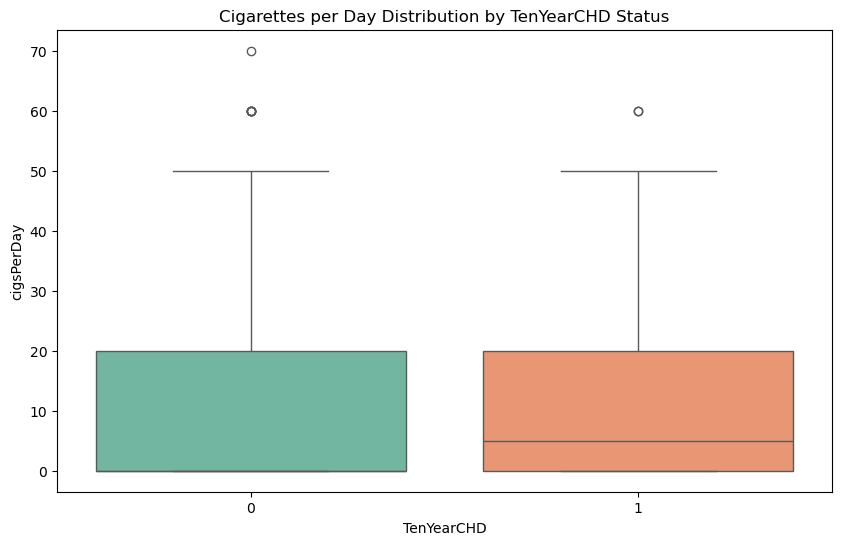

In [147]:
# Cigarettes per day and TenYearCHD
medians = df.groupby('TenYearCHD')['cigsPerDay'].median()
print('Median Cigarettes per Day for TenYearCHD=0:', medians[0])
print('Median Cigarettes per Day for TenYearCHD=1:', medians[1])
plt.figure(figsize=(10, 6))
sns.boxplot(x='TenYearCHD', y='cigsPerDay', data=df, palette='Set2')
plt.title('Cigarettes per Day Distribution by TenYearCHD Status')
plt.show()

As hypothesized, smokers and those with diabetes, hypertension, or stroke have higher CHD rates. The largest difference is seen in stroke patients: 45.45% have CHD compared to stroke-free participants.

Median Cholesterol for TenYearCHD=0: 233.0
Median Cholesterol for TenYearCHD=1: 242.0


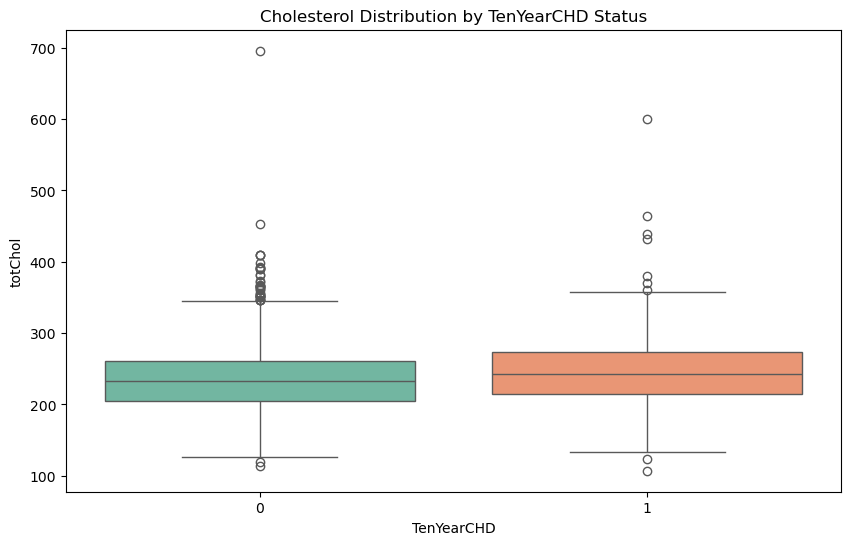

In [148]:
# Cholesterol and TenYearCHD
medians = df.groupby('TenYearCHD')['totChol'].median()
print('Median Cholesterol for TenYearCHD=0:', medians[0])
print('Median Cholesterol for TenYearCHD=1:', medians[1])
plt.figure(figsize=(10, 6))
sns.boxplot(x='TenYearCHD', y='totChol', data=df, palette='Set2')
plt.title('Cholesterol Distribution by TenYearCHD Status')
plt.show()


Median Systolic Blood Pressure for TenYearCHD=0: 127.0
Median Systolic Blood Pressure for TenYearCHD=1: 139.0


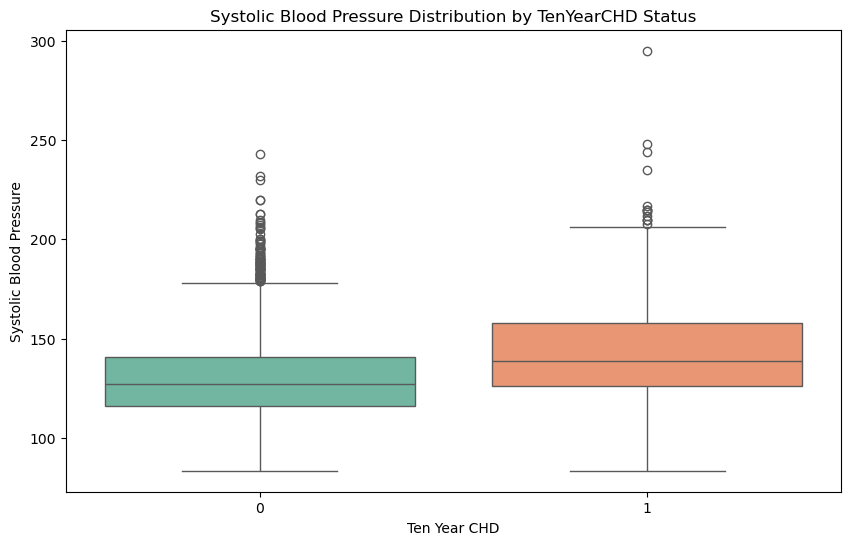

Median Diastolic Blood Pressure for TenYearCHD=0: 81.0
Median Diastolic Blood Pressure for TenYearCHD=1: 85.0


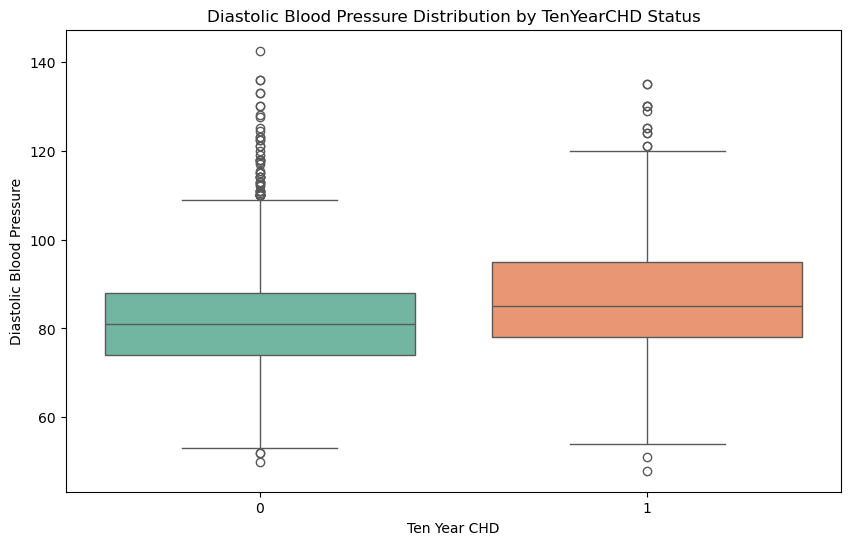

In [149]:
# Blood pressures and TenYearCHD
medians = df.groupby('TenYearCHD')['sysBP'].median()
print('Median Systolic Blood Pressure for TenYearCHD=0:', medians[0])
print('Median Systolic Blood Pressure for TenYearCHD=1:', medians[1])
plt.figure(figsize=(10, 6))
sns.boxplot(x='TenYearCHD', y='sysBP', data=df, palette='Set2')
plt.title('Systolic Blood Pressure Distribution by TenYearCHD Status')
plt.xlabel('Ten Year CHD')
plt.ylabel('Systolic Blood Pressure')
plt.show()

medians = df.groupby('TenYearCHD')['diaBP'].median()
print('Median Diastolic Blood Pressure for TenYearCHD=0:', medians[0])
print('Median Diastolic Blood Pressure for TenYearCHD=1:', medians[1])
plt.figure(figsize=(10, 6))
sns.boxplot(x='TenYearCHD', y='diaBP', data=df, palette='Set2')
plt.title('Diastolic Blood Pressure Distribution by TenYearCHD Status')
plt.xlabel('Ten Year CHD')
plt.ylabel('Diastolic Blood Pressure')
plt.show()

Median BMI for TenYearCHD=0: 25.25
Median BMI for TenYearCHD=1: 26.13


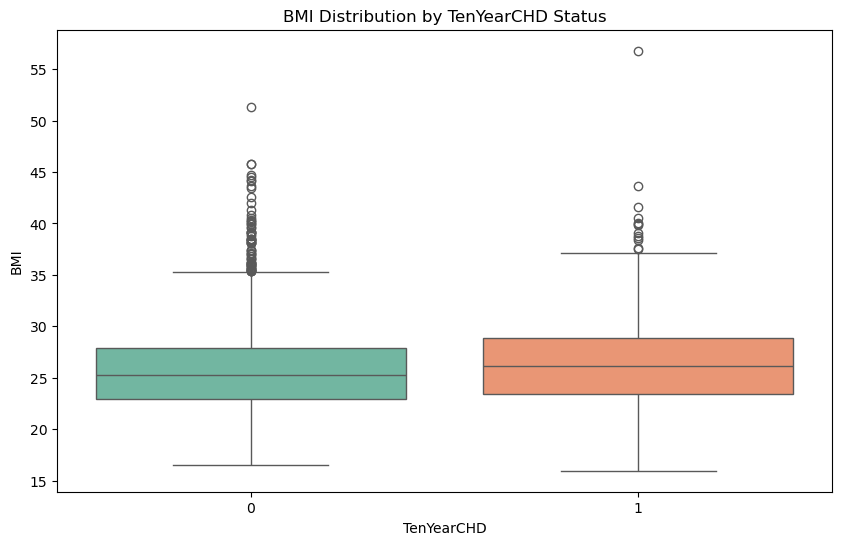

In [150]:
# BMI and TenYearCHD
medians = df.groupby('TenYearCHD')['BMI'].median()
print('Median BMI for TenYearCHD=0:', medians[0])
print('Median BMI for TenYearCHD=1:', medians[1])
plt.figure(figsize=(10, 6))
sns.boxplot(x='TenYearCHD', y='BMI', data=df, palette='Set2')
plt.title('BMI Distribution by TenYearCHD Status')
plt.show()

Median heart rate for TenYearCHD=0: 75.0
Median heart rate for TenYearCHD=1: 75.0


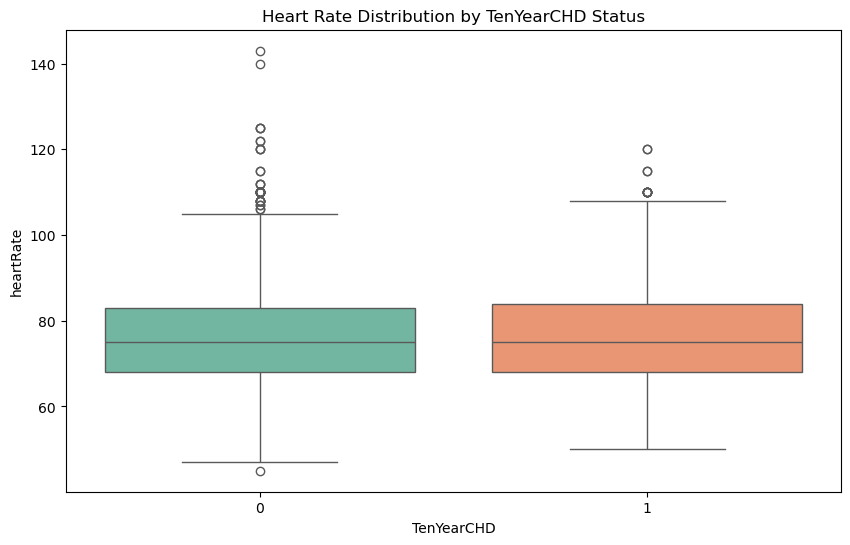

In [151]:
# Heart rate and TenYearCHD
medians = df.groupby('TenYearCHD')['heartRate'].median()
print('Median heart rate for TenYearCHD=0:', medians[0])
print('Median heart rate for TenYearCHD=1:', medians[1])
plt.figure(figsize=(10, 6))
sns.boxplot(x='TenYearCHD', y='heartRate', data=df, palette='Set2')
plt.title('Heart Rate Distribution by TenYearCHD Status')
plt.show()

Median glucose for TenYearCHD=0: 79.0
Median glucose for TenYearCHD=1: 80.0


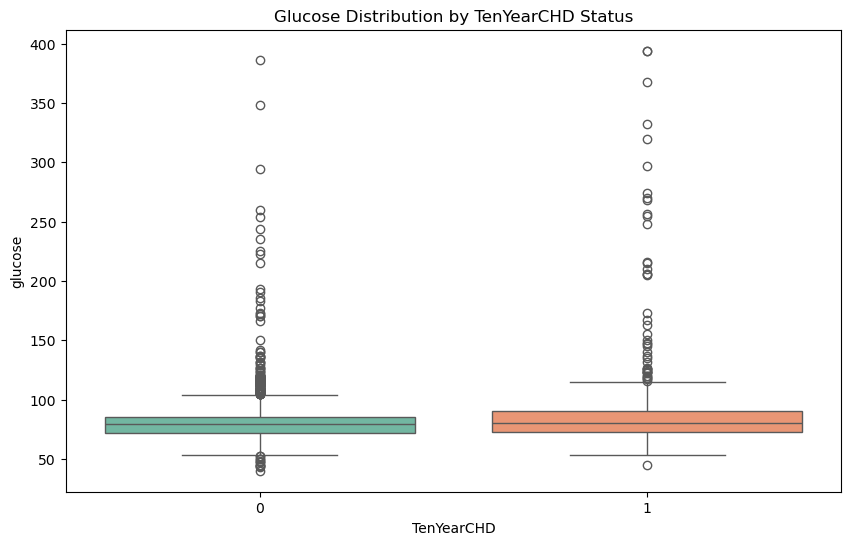

In [152]:
# Glucose and TenYearCHD
medians = df.groupby('TenYearCHD')['glucose'].median()
print('Median glucose for TenYearCHD=0:', medians[0])
print('Median glucose for TenYearCHD=1:', medians[1])

plt.figure(figsize=(10, 6))
sns.boxplot(x='TenYearCHD', y='glucose', data=df, palette='Set2')
plt.title('Glucose Distribution by TenYearCHD Status')
plt.show()

- Individuals with TenYearCHD=1 tend to have higher BMI, blood pressure, cholesterol, and glucose levels compared to those with TenYearCHD=0, although these differences are not large. Heart rates are similar between the groups.
- The importance of these features as risk factors—and whether they significantly predict CHD—needs to be tested.

## Logistic Regression Model

In [153]:
# Data transformation with robust scaling to lessen the impact of outliers
scaler = RobustScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


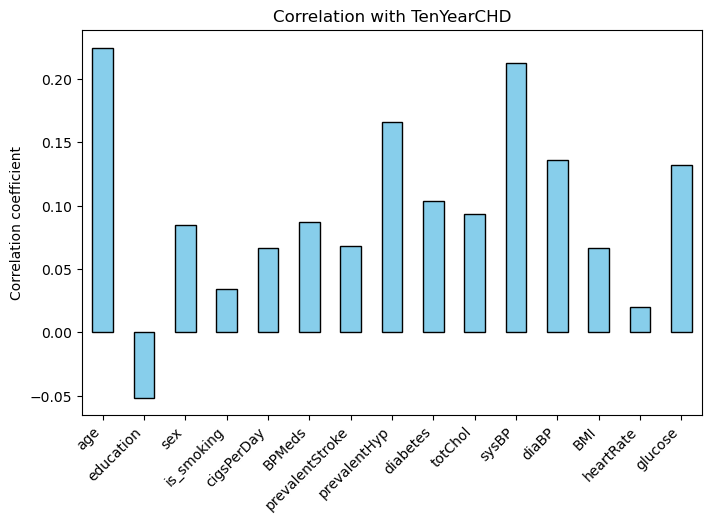

In [154]:
# Risk factor correlations with TenYearCHD
corr_with_target = df.corr()["TenYearCHD"].drop("TenYearCHD")
corr_with_target.plot(kind="bar", figsize=(8, 5), color="skyblue", edgecolor="black")
plt.title("Correlation with TenYearCHD")
plt.ylabel("Correlation coefficient")
plt.xticks(rotation=45, ha="right")
plt.show()


Sex: male gender (1) correlates with CHD. 

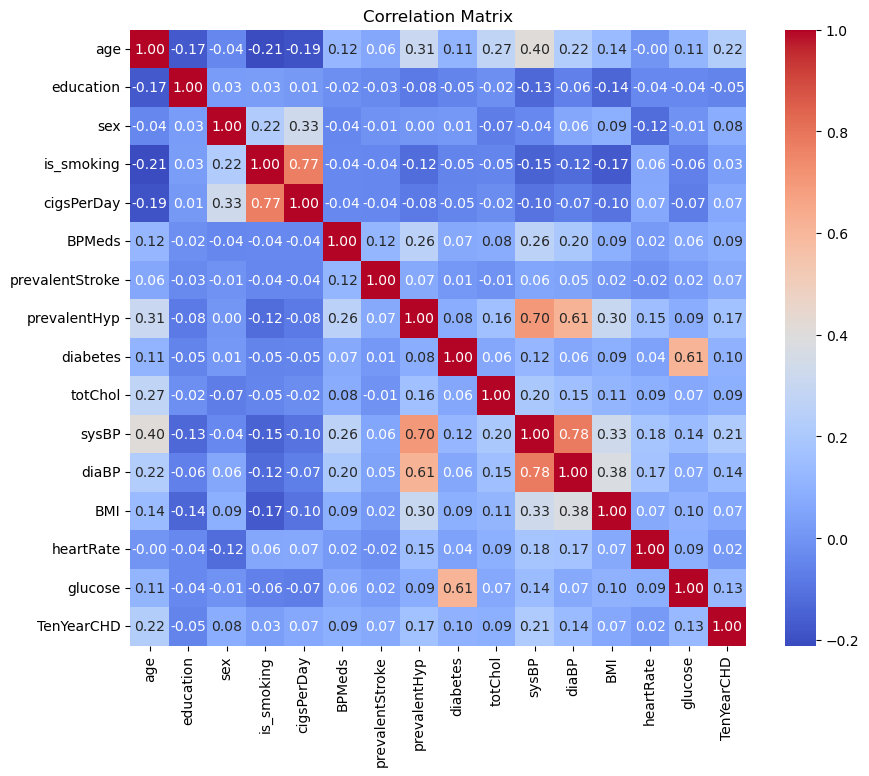

In [155]:
# Correlation matrix: evaluating collinearity
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

In [156]:
# Variance Inflation Factor calculations 
X = df.drop(columns=["TenYearCHD"])
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(X.shape[1])]

vif_data = vif_data[vif_data["Feature"] != "const"]

print(vif_data)

            Feature       VIF
1               age  1.377884
2         education  1.056738
3               sex  1.209096
4        is_smoking  2.542163
5        cigsPerDay  2.672898
6            BPMeds  1.103721
7   prevalentStroke  1.020683
8      prevalentHyp  2.052639
9          diabetes  1.597735
10          totChol  1.113037
11            sysBP  3.745655
12            diaBP  2.905720
13              BMI  1.241757
14        heartRate  1.092919
15          glucose  1.616212


VIF values are acceptable. However, as expected, some variables are highly related (correlation matrix):
- "prevalentHyp" correlates with blood pressure (0.6–0.7),
- "is_smoking" correlates with "cigsPerDay" (0.77),
- "diabetes" correlates with "glucose" (0.6).
To avoid multicollinearity, the categorical variables are dropped, keeping their continuous counterparts.

Confusion Matrix:
 [[415 161]
 [ 35  67]]

Classification Report:
               precision    recall  f1-score   support

           0      0.922     0.720     0.809       576
           1      0.294     0.657     0.406       102

    accuracy                          0.711       678
   macro avg      0.608     0.689     0.608       678
weighted avg      0.828     0.711     0.748       678

AUC: 0.7238902505446623


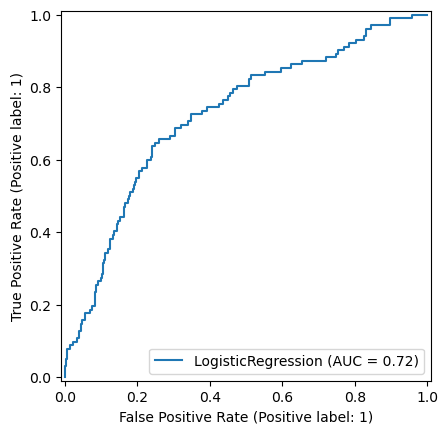

In [157]:
X = df.drop(columns=["TenYearCHD", "prevalentHyp", "is_smoking", "diabetes"]) 

# Splitting training and testing
y = df["TenYearCHD"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


log_reg_balanced = LogisticRegression(max_iter=1000, class_weight="balanced") # class_weight to handle class imbalance
log_reg_balanced.fit(X_train, y_train)

y_pred = log_reg_balanced.predict(X_test)
y_proba = log_reg_balanced.predict_proba(X_test)[:, 1]


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("AUC:", roc_auc_score(y_test, y_proba))


# ROC Curve
RocCurveDisplay.from_estimator(log_reg_balanced, X_test, y_test)
plt.show()

In [158]:
pr_auc = average_precision_score(y_test, y_probs)
print(f"PR AUC: {pr_auc:.3f}")

PR AUC: 0.337


Above what a random classifier would get (~ PR AUC 0.15) but still weak.

The model predicts the majority class (no CHD) well; however, in healthcare contexts, sensitivity to disease diagnosis is highly important. Accuracy alone can be misleading, as a model could achieve high accuracy by simply predicting the majority class and missing most CHD cases. The F1 score is a more appropriate classification metric because it balances precision (how many predicted CHD cases are correct) and recall (sensitivity to detecting CHD cases).

The model is optimized for the best F1 score by selecting the decision threshold that maximizes F1:

Best threshold for F1: 0.53
Best F1 score: 0.426
Precision at best threshold: 0.320
Recall at best threshold: 0.637


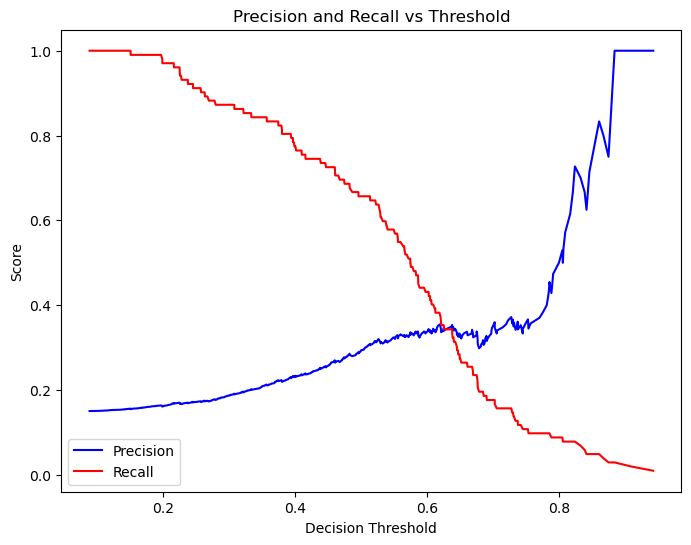

In [159]:
y_probs = log_reg_balanced.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold for F1: {best_threshold:.2f}")
print(f"Best F1 score: {best_f1:.3f}")
print(f"Precision at best threshold: {precisions[best_idx]:.3f}")
print(f"Recall at best threshold: {recalls[best_idx]:.3f}")

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="b")
plt.plot(thresholds, recalls[:-1], label="Recall", color="r")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.show()

Confusion Matrix:
 [[438 138]
 [ 37  65]]

Classification Report:
               precision    recall  f1-score   support

           0      0.922     0.760     0.833       576
           1      0.320     0.637     0.426       102

    accuracy                          0.742       678
   macro avg      0.621     0.699     0.630       678
weighted avg      0.832     0.742     0.772       678

AUC: 0.7238902505446623


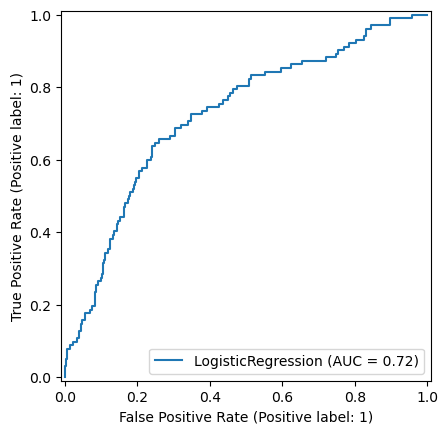

In [160]:
# Updating model
X = df.drop(columns=["TenYearCHD", "prevalentHyp", "is_smoking", "diabetes"]) 
y = df["TenYearCHD"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg_balanced = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg_balanced.fit(X_train, y_train)

y_proba = log_reg_balanced.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= best_threshold).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(log_reg_balanced, X_test, y_test)
plt.show()

Optimization terminated successfully.
         Current function value: 0.374555
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 2712
Model:                          Logit   Df Residuals:                     2699
Method:                           MLE   Df Model:                           12
Date:                Fri, 29 Aug 2025   Pseudo R-squ.:                  0.1169
Time:                        14:41:10   Log-Likelihood:                -1015.8
converged:                       True   LL-Null:                       -1150.2
Covariance Type:            nonrobust   LLR p-value:                 1.616e-50
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.6339      0.156    -16.863      0.000      -2.940      -2.328
age           

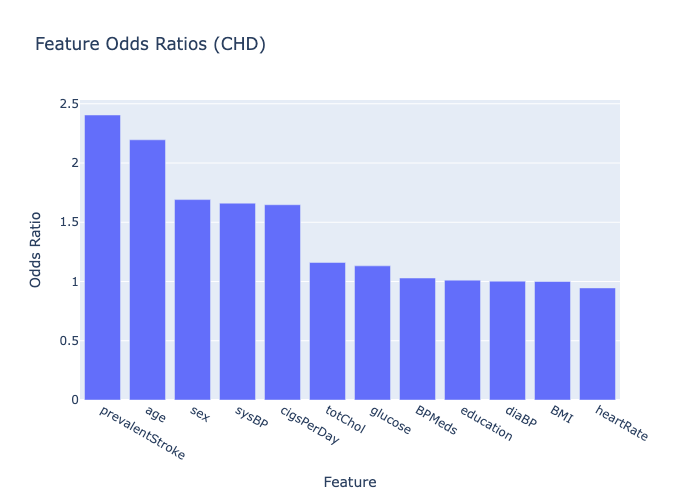

In [161]:
X_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_const)
result = logit_model.fit()

print(result.summary()) 


odds_ratios = pd.DataFrame({
    'Feature': X.columns,
    'Odds Ratio': np.exp(result.params[1:]) 
})
odds_ratios = odds_ratios.sort_values(by='Odds Ratio', ascending=False)

print(odds_ratios)

fig = px.bar(odds_ratios, x='Feature', y='Odds Ratio', title='Feature Odds Ratios (CHD)')
fig.write_image("plot.png")
display(Image(filename="plot.png"))

The most influential risk factors for coronary heart disease (CHD) are stroke history, older age, male sex, and cigarette smoking:
- Having a previous stroke increases the odds of CHD by 2.4 times.
- Each additional year of age nearly doubles the odds of CHD (odds ratio: 2.19), indicating a very strong effect.
- Males have 1.69 times higher odds of CHD compared to females.
- Each additional cigarette smoked per day raises the odds of CHD by 1.65 times.

Blood pressure medication, diastolic blood pressure, education level, and BMI have negligible effects on CHD risk, while higher heart rate is associated with lower risk.

Next steps:
- For imbalance handling, compare class_weight="balanced" and SMOTE with cross-validation
- Alternative models to Logistic Regression: Random Forest, Gradient Boosting (XGBoost/LightGBM)
- Clinical utility: calculate FN vs FP cost, subgroup analysis